In [1]:
from css_utility import *

/home/lee/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### First, save the long-version of css

In [2]:
df_pickle_path="../database/roadmap/df_pickled"

In [3]:
df_pickle_path_test_cell=df_pickle_path+"/E001_df_pickled.pkl"

In [4]:
with open(df_pickle_path_test_cell, "rb") as f:
    test_cell_df=pickle.load(f) # one long 

In [5]:
len(test_cell_df)

510150

In [13]:
def remove_chrM_and_trim_gene_file_accordingly(whole_gene_file,df):
    
    ########### new fancy gene table without overlap ###########
    g_df_chr_lst=whGene2GLChr(whole_gene_file)  ##### fixed June 29. 2023
    new_gene_lst_all=merge_intervals(g_df_chr_lst) ##### fixed June 29. 2023
    ############################################################

    #### Remove chrM ###########################################
    contains_chrM = df['chromosome'].str.contains('chrM').any()  #check whether it contains M
    if contains_chrM:
        df= df[~df['chromosome'].str.contains('chrM')]

    contains_chrY = df['chromosome'].str.contains('chrY').any()

    ##### if the target file does not contain Y, remove Y in the gene list file
    if not contains_chrY:
        new_gene_lst_all=new_gene_lst_all[:-1] ## the final element is for Y
    ############################################################

    assert len(df["chromosome"].unique())==len(new_gene_lst_all)
    return new_gene_lst_all, df

In [14]:
new_gene_lst_all, df_wo_chrM=remove_chrM_and_trim_gene_file_accordingly(whole_gene_file,test_cell_df)

Extracting the gene file ...
Done!


In [23]:
df_wo_chrM["chromosome"].str.contains('chrM')

0         False
1         False
2         False
3         False
4         False
          ...  
510145    False
510146    False
510147    False
510148    False
510149    False
Name: chromosome, Length: 510142, dtype: bool

In [25]:
css_long_test=df2longcss(df_wo_chrM)

In [27]:
type(css_long_test[0])

str

In [35]:
new_gene_lst_all[0]["TxStart"]

0           11873
1           30365
2           34610
3           69090
4          134772
          ...    
2055    249104650
2056    249120575
2057    249132376
2058    249144202
2059    249200441
Name: TxStart, Length: 2060, dtype: int64

In [37]:
css_long_test[0][11873:11973]

'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO'

In [12]:
def save_TSS_by_loc(whole_gene_file, input_path="../database/roadmap/df_pickled/",output_path="../database/roadmap/prom/up2kdown4k/", up_num=2000, down_num=4000, unit=200):
    """
    extract TSS region by location estimation. 
    input: (1) whole_gene_file: the raw gene bed file (2) input_path: pickled df per cell
    output: save tss_by_loc_css_unit_all at the output path
    """
    file_lst=os.listdir(input_path)
    all_files=[os.path.join(input_path,file) for file in file_lst]
    for file in all_files:
        cell_num=file.split("/")[-1][:4]
#         if cell_num=="E002": break  # for test 
        with open(file,"rb") as f:
            df_pickled=pickle.load(f)
        # align the gene file and the df file according to their availability(some cells does not have chr Y)
        new_gene_lst_all, trimmed_df=remove_chrM_and_trim_gene_file_accordingly(whole_gene_file,df_pickled)
        css_lst_chr = df2longcss(trimmed_df) # list of long css per chromosome
        total_chr = len(new_gene_lst_all)       
        tss_by_loc_css_all = []
        for i in range(total_chr):
            gene_start_lst = new_gene_lst_all[i]["TxStart"]
            css_lst = css_lst_chr[i]
            tss_by_loc_css_chr = []
            for j in range(len(gene_start_lst)):
                gene_start = gene_start_lst[j]
                win_start = max(0, gene_start - up_num)  # use max to prevent negative index
                win_end = min(len(css_lst), gene_start + down_num)  # use min to prevent index out of range
                tss_by_loc_css = css_lst[win_start:win_end]
                tss_by_loc_css_chr.append(tss_by_loc_css)               
            tss_by_loc_css_all.append(tss_by_loc_css_chr)
        tss_by_loc_css_unit_all=Convert2unitCSS_main_new(tss_by_loc_css_all, unit=unit)  
        output_file_name=os.path.join(output_path,cell_num+"_prom_up2kdown4k.pkl")
        with open(output_file_name,"wb") as g:
            pickle.dump(tss_by_loc_css_unit_all,g)

    return print("All done!") #tss_by_loc_css_unit_all

In [13]:
tss_by_loc_css_unit_all=save_TSS_by_loc(whole_gene_file, input_path="../database/roadmap/df_pickled/",output_path="../database/roadmap/prom/up2kdown4k/", up_num=2000, down_num=4000, unit=200)

Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene file ...
Done!
Extracting the gene 

In [14]:
### test how many TSSs (A) are found there 
with open("../database/roadmap/prom/up2kdown4k/E001_prom_up2kdown4k.pkl","rb") as f:
    prom_e001=pickle.load(f)

In [15]:
prom_e001=flatLst(prom_e001)
len(prom_e001)

21148

In [18]:
prom_a=[]
for prom in prom_e001:
    if "A" in prom:
        prom_a.append(prom)
len(prom_a)/len(prom_e001)

0.32594098732740684

In [19]:
len(prom_a)

6893

In [42]:
def prom_stat1(prom_path="../database/roadmap/prom/up2kdown4k/", chromatin_state="A"):
    file_lst=os.listdir(prom_path)
    all_files=sorted([os.path.join(prom_path,file) for file in file_lst])
    
    occu_cs_all=[]
    prom_cs_all=[]
    for file in all_files:
        cell_num=file.split("/")[-1][:4]
#         if cell_num=="E004": break   ### for test
        with open(file,"rb") as f:
            prom=pickle.load(f)
        prom=flatLst(prom) #### flatten for all chromosomes       
        prom_cs=[item for item in prom if chromatin_state in item]
        prom_cs_all.append(prom_cs)
        
        total_entry=len(prom)
        cs_entry=len(prom_cs)
        occu_cs=cs_entry/total_entry ### percentage of proms which include certain CS
        occu_cs_all.append(occu_cs)
        
    return prom_cs_all, occu_cs_all
        

In [43]:
prom_cs_all_allepi, occu_cs_all_allepi=prom_stat1(prom_path="../database/roadmap/prom/up2kdown4k/", chromatin_state="A")

In [45]:
len(prom_cs_all_allepi)

127

In [46]:
len(occu_cs_all_allepi)

127

In [48]:
prom_cs_all_allepi[20][200]

'AAAAAAAAAAAABBBEEEEEEEEEEEEEEE'

In [49]:
def prom_stat1(prom_path="../database/roadmap/prom/up2kdown4k/", chromatin_state="A"):
    file_lst=os.listdir(prom_path)
    all_files=sorted([os.path.join(prom_path,file) for file in file_lst])
    
    occu_cs_all=[]
    prom_cs_all=[]
    for file in all_files:
        cell_num=file.split("/")[-1][:4]
#         if cell_num=="E004": break   ### for test
        with open(file,"rb") as f:
            prom=pickle.load(f)
        prom=flatLst(prom) #### flatten for all chromosomes       
        prom_cs=[item for item in prom if chromatin_state in item]
        prom_cs_all.append(prom_cs)
        
        total_entry=len(prom)
        cs_entry=len(prom_cs)
        occu_cs=cs_entry/total_entry ### percentage of proms which include certain CS
        occu_cs_all.append(occu_cs)
        
    return prom_cs_all, occu_cs_all

In [50]:
prom_cs_all, occu_cs_all=prom_stat1(prom_path="../database/roadmap/prom/up2kdown4k/", chromatin_state="A")

In [55]:
len(flatLst(prom_cs_all))

875309

Text(0.5, 1.0, 'Proportion of genes having active TSS on u2kd4k regions (total 127 cells)')

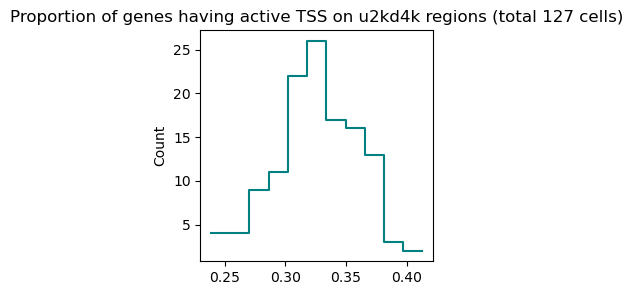

In [75]:
plt.figure(figsize=(3,3))
sns.histplot(occu_cs_all,color="teal", element="step", fill=None)
plt.title("Proportion of genes having active TSS on u2kd4k regions (total 127 cells)")
# plt.ylim(0,1)

#### It seems like promoters are not necessarily to be located in the promoter regions, there are alternative splicing-related promoters and reverse transcription. So I think it is better to extract the Active TSS regions (A) in the gene, which has higher RPKM. Because our previous rpkm gene data is obsolete, we need to rerun those things.

In [76]:
g_df_chr_collapsed_lst=Gexp_Gene2GLChr(exp_gene_file='../database/bed/gene_expression/E050/gene_highlyexpressed.refFlat')

Extracting the gene file ...
Done!


In [87]:
test_ref=pd.read_csv('../database/roadmap/gene_exp/refFlat_byCellType/rpkm50/E003_gene_highlyexpressed.refFlat', sep='\t', header=None)

In [88]:
test_ref

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,NaN,#geneName,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,gene type,transcript type,reference transcript name,reference transcript id
1,ENSG00000001630,CYP51A1,ENSG00000001630,chr7,-,91741464,91763844,91742978,91763678,10,"[91741464, 91746357, 91747833, 91752433, 91753...","[91743157, 91746526, 91747929, 91752629, 91753...",protein_coding,protein_coding,CYP51A1-001,ENST00000003100
2,ENSG00000002834,LASP1,ENSG00000002834,chr17,+,37026111,37078023,37026442,37075031,7,"[37026111, 37034338, 37046672, 37054664, 37070...","[37026511, 37034433, 37046757, 37054772, 37070...",protein_coding,protein_coding,LASP1-001,ENST00000318008
3,ENSG00000003056,M6PR,ENSG00000003056,chr12,-,9092960,9102551,9094413,9099000,7,"[9092960, 9095011, 9096000, 9096396, 9098013, ...","[9094536, 9095138, 9096131, 9096506, 9098180, ...",protein_coding,protein_coding,M6PR-001,ENST00000000412
4,ENSG00000004059,ARF5,ENSG00000004059,chr7,+,127228398,127231759,127228552,127231353,6,"[127228398, 127229136, 127229538, 127230119, 1...","[127228619, 127229217, 127229648, 127230191, 1...",protein_coding,protein_coding,ARF5-001,ENST00000000233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,ENSG00000258466,RP11-1012A1.4,ENSG00000258466,chr14,-,68126536,68157084,68129897,68157084,5,"[68126536, 68129193, 68129745, 68151731, 68156...","[68126639, 68129252, 68129907, 68151921, 68157...",protein_coding,nonsense_mediated_decay,RP11-1012A1.4-001,ENST00000553306
1255,ENSG00000258643,BCL2L2-PABPN1,ENSG00000258643,chr14,+,23776043,23794578,23776976,23794495,9,"[23776043, 23776400, 23776968, 23791389, 23792...","[23776103, 23776488, 23777408, 23791504, 23792...",protein_coding,protein_coding,BCL2L2-PABPN1-001,ENST00000553781
1256,ENSG00000258674,CTC-260F20.3,ENSG00000258674,chr19,+,19627035,19646885,19627047,19646619,7,"[19627035, 19636990, 19638089, 19638509, 19645...","[19627141, 19637069, 19638161, 19638579, 19645...",protein_coding,protein_coding,CTC-260F20.3-001,ENST00000555938
1257,ENSG00000259112,NDUFC2-KCTD14,ENSG00000259112,chr11,-,77728091,77790911,77728281,77790790,3,"[77728091, 77784043, 77790624]","[77728316, 77784187, 77790911]",protein_coding,protein_coding,NDUFC2-KCTD14-001,ENST00000530054


In [85]:
def extExpGenic_byCell_1_ver02(output_path="../database/roadmap/gene_exp/refFlat_byCellType/", all_file=True, high_only=True, verbose=True, exp=0, high_exp=50, **kwargs):
    """
    RUN THE SECOND function 'extExpGenic_byCell_2_ver02' after running this function.
    This pipeline is to extract CSS expressed genic region, mainly for "expressed" and "highly-expressed"
    In this function, the refFlat file for each epigenomes are extracted and saved at output path
    
    **** You need to create the folder first, at the save path
    
    (1) To process all the  ... set 'all_file=True'.
        If you want to process only one file at a time, set e.g.) all_file=False, file="E050_15_coreMarks_stateno.bed"
    (2) High_only = True will only produce the highly expressed cases (default) 
    (3) Outputs are e.g.) "E112_gene_expressed.refFlat", "E112_gene_highlyexpressed.refFlat" at output path
    """
    
    output_path_mod=output_path+"rpkm"+str(high_exp)+"/"
    
    path="../database/roadmap/gene_exp/"
    script="classifygenes_ROADMAP_RPKM.py"
    epi_rpkm_tsv="57epigenomes.RPKM.pc.tsv"
    gene_ref="chr.gene.refFlat"
    original_path="~/Work/chromatin_state/NSP/"
    
    save_path="./refFlat_byCellType/"+"rpkm"+str(high_exp)+"/"
    css_bed_path="../database/bed/unzipped/"

    if all_file:
        css_gene_path="../database/temp_files/whole_gene_unit/"
        # File list of CSS on genic region for all cell types
        files_under_folder=sorted(os.listdir(css_gene_path))
        cell_gene_css_all=[file for file in files_under_folder if file.startswith('E') and file.endswith('.pkl')]
    
        if verbose: print("processing all files ...")
        for epi_css in tqdm_notebook(cell_gene_css_all):             
            epi_num=epi_css[:4] # e.g.) E003
            
            if verbose: print("{} is now processed ...".format(epi_num))
            file_path=css_bed_path+epi_css
#             df=bed2df_expanded(file_path)  # css df

            ######## Running the script at working path and come back to the original path #########
            %cd -q {path}
            %run {script} --thre_expressed {exp} --thre_highlyexpressed {high_exp} {epi_rpkm_tsv} {epi_num} {gene_ref}

            if not high_only:
                exp_file_name=save_path+epi_num+"_"+"gene_expressed.refFlat"
            hexp_file_name=save_path+epi_num+"_"+"gene_highlyexpressed.refFlat"
            %mv "gene_expressed.refFlat" {exp_file_name}
            %mv "gene_highlyexpressed.refFlat" {hexp_file_name}
            %cd -q {original_path}
            ########################################################################################
                
        
    elif len(kwargs)>0:       
        for file_key, file_name in kwargs.items():            
            epi_num=file_name[:4]
            if verbose: print("all_file=False, processing single case for {}.".format(epi_num))

            file_path=css_bed_path+file_name
#             df=bed2df_expanded(file_path)  # css df for the designated file
            
            ######## Running the script at working path and come back to the original path #########
            %cd -q {path}
            %run {script} --thre_expressed {exp} --thre_highlyexpressed {high_exp} {epi_rpkm_tsv} {epi_num} {gene_ref}

            if not high_only:
                exp_file_name=save_path+epi_num+"_"+"gene_expressed.refFlat"
            hexp_file_name=save_path+epi_num+"_"+"gene_highlyexpressed.refFlat"
            %mv "gene_expressed.refFlat" {exp_file_name}
            %mv "gene_highlyexpressed.refFlat" {hexp_file_name}
            %cd -q {original_path}
            ########################################################################################
            
    else:
        raise ValueError("Set all_file=True, or desginate any file name to proceed!")
    assert os.getcwd()[-3:]=="NSP", "Check the current working directory."
    
    return print("Results are stored at {}, and current working directory is : {}".format(output_path_mod, os.getcwd()))
                           

In [92]:
extExpGenic_byCell_1_ver02(output_path="../database/roadmap/gene_exp/refFlat_byCellType/", all_file=True, high_only=False, verbose=True, exp=0, high_exp=10)

processing all files ...


  0%|          | 0/56 [00:00<?, ?it/s]

E003 is now processed ...
E004 is now processed ...
E005 is now processed ...
E006 is now processed ...
E007 is now processed ...
E011 is now processed ...
E012 is now processed ...
E013 is now processed ...
E016 is now processed ...
E024 is now processed ...
E027 is now processed ...
E028 is now processed ...
E037 is now processed ...
E038 is now processed ...
E047 is now processed ...
E050 is now processed ...
E053 is now processed ...
E054 is now processed ...
E055 is now processed ...
E056 is now processed ...
E057 is now processed ...
E058 is now processed ...
E059 is now processed ...
E061 is now processed ...
E062 is now processed ...
E065 is now processed ...
E066 is now processed ...
E070 is now processed ...
E071 is now processed ...
E079 is now processed ...
E082 is now processed ...
E084 is now processed ...
E085 is now processed ...
E087 is now processed ...
E094 is now processed ...
E095 is now processed ...
E096 is now processed ...
E097 is now processed ...
E098 is now 

In [2]:
def extExpGenic_byCell_2_ver02(output_path="../database/roadmap/gene_exp/css_byCellType/",all_file=True, high_only=True, high_exp=50, verbose=True, **kwargs):
    """
    Should be executed after extExpGenic_byCell_1_ver01
    modified the previous version to make it applicalbe to highly_expressed only extraction
    with high_only=True, highly expressed gene according to the high_exp value (RPKM) are extracted.
    """
    exp_ref_path="../database/roadmap/gene_exp/refFlat_byCellType/rpkm0/"
    hexp_ref_path="../database/roadmap/gene_exp/refFlat_byCellType/"+"rpkm"+str(high_exp)+"/"
    
    ref_exp_file_all=sorted(os.listdir(exp_ref_path))
    ref_hexp_file_all=sorted(os.listdir(hexp_ref_path))
    
    ref_exp_all=[elm for elm in ref_exp_file_all if '_expressed' in elm and elm.startswith('E')]
    ref_hexp_all=[elm for elm in ref_hexp_file_all if 'high' in elm and elm.startswith('E')]
      
    css_gene_path="../database/roadmap/gene_css_unit_pickled/"  # this is without chrM
    css_bed_path="../database/bed/unzipped/"
    css_bed_file_all=sorted(os.listdir(css_bed_path))    

    if all_file:
        if verbose: print("processing all files ...")
        for epi_css in tqdm_notebook(ref_hexp_all):
            epi_num=epi_css[:4]
            if verbose: print("{} is now processed ...".format(epi_num))
#             ########### preparing df from bed
#             target_bed=[elm for elm in css_bed_file_all if elm[:4]==epi_num]
#             bed_path=css_bed_path+target_bed[0]
#             df=bed2df_expanded(bed_path)
            
            ## load pickled df, to reduce the computation load
            epi_df_path="../database/roadmap/df_pickled/"+epi_num+"_df_pickled.pkl"
            with open(epi_df_path, "rb") as f:
                df=pickle.load(f)
            df = df[df['chromosome'] != 'chrM']   # to remove the chromosome M

            # preparing ref from exp_refs
            target_hexp_ref=[elm for elm in ref_hexp_all if elm[:4]==epi_num]
            target_exp_ref=[elm for elm in ref_exp_all if elm[:4]==epi_num]
            hexp=hexp_ref_path+target_hexp_ref[0]
            exp=exp_ref_path+target_exp_ref[0]

            if not high_only:  # extract just 'expressed' case if high_only is False (default=True)
                css_exp_gene_lst=comp_expGene2css(exp,df)  
                css_exp_gene_unit_lst=flatLst(Convert2unitCSS_main_new(css_exp_gene_lst, unit=200)) # new
                with open(output_path+"rpkm0/"+epi_num+"_exp_gene_css.pkl","wb") as g:
                    pickle.dump(css_exp_gene_unit_lst,g)
                    
            css_hexp_gene_lst=comp_expGene2css(hexp,df)
            css_hexp_gene_unit_lst=flatLst(Convert2unitCSS_main_new(css_hexp_gene_lst, unit=200)) #new
            with open(output_path+"rpkm"+str(high_exp)+"/"+epi_num+"_rpkm"+str(high_exp)+"_exp_gene_css.pkl","wb") as f:
                pickle.dump(css_hexp_gene_unit_lst,f)
            
    elif "file" in kwargs:
        file_name=kwargs["file"]
#         for file_key, file_name in kwargs.items():            
        epi_num=file_name[:4]
        if verbose: print("all_file=False, processing single case for {}.".format(epi_num))
        # preparing df from bed
        target_bed=[elm for elm in css_bed_file_all if elm[:4]==epi_num]
        bed_path=css_bed_path+target_bed[0]
        df=bed2df_expanded(bed_path)
        # preparing ref from exp_refs
        target_hexp_ref=[elm for elm in ref_hexp_all if elm[:4]==epi_num]
        target_exp_ref=[elm for elm in ref_exp_all if elm[:4]==epi_num]
        hexp=hexp_ref_path+target_hexp_ref[0]
        exp=exp_ref_path+target_exp_ref[0] 
        
        if not high_only:  # extract just 'expressed' case if high_only is False (default=True)
            css_exp_gene_lst=comp_expGene2css(exp,df)
            css_exp_gene_unit_lst=flatLst(Convert2unitCSS_main_new(css_exp_gene_lst, unit=200))
            with open(output_path+"rpkm0/"+epi_num+"_exp_gene_css.pkl","wb") as g:
                pickle.dump(css_exp_gene_unit_lst,g)

        css_hexp_gene_lst=comp_expGene2css(hexp,df)
        css_hexp_gene_unit_lst=flatLst(Convert2unitCSS_main_new(css_hexp_gene_lst, unit=200))
        with open(output_path+"rpkm"+str(high_exp)+"/"+epi_num+"_rpkm"+str(high_exp)+"_exp_gene_css.pkl","wb") as f:
            pickle.dump(css_hexp_gene_unit_lst,f)

    else:
        raise ValueError("Set all_file=True, or desginate any file name to proceed!")
    return

In [9]:
extExpGenic_byCell_2_ver02(output_path="../database/roadmap/gene_exp/css_byCellType/",all_file=True, high_only=False, high_exp=10, verbose=True)

processing all files ...


  0%|          | 0/56 [00:00<?, ?it/s]

E003 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E004 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E005 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E006 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E007 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E011 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E012 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E013 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E016 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E024 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E027 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E028 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E037 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E038 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E047 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E050 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E053 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E054 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E055 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E056 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E057 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E058 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E059 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E061 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E062 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E065 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E066 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E070 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E071 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E079 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E082 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E084 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E085 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E087 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E094 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E095 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E096 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E097 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E098 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E100 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E104 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E105 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E106 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E109 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E112 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E113 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E114 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E116 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E117 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E118 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E119 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E120 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E122 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E123 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E127 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E128 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!


In [138]:
with open("../database/roadmap/gene_exp/css_byCellType/rpkm50/E003_rpkm50_exp_gene_css.pkl","rb") as f:
    tt=pickle.load(f)

In [4]:
with open("../database/roadmap/gene_exp/css_byCellType/rpkm50/E116_rpkm50_exp_gene_css.pkl","rb") as f:
    tt116=pickle.load(f)

In [5]:
len(tt116)

1264

In [106]:
t_path='../database/roadmap/gene_exp/refFlat_byCellType/rpkm30/E003_gene_highlyexpressed.refFlat'

In [114]:
c_path='../database/roadmap/gene_exp/refFlat_byCellType/rpkm30/E116_gene_highlyexpressed.refFlat'

In [107]:
g_df_chr_collapsed_lst=Gexp_Gene2GLChr(t_path)

Extracting the gene file ...
Done!


In [115]:
g_df_chr_collapsed_lst_c=Gexp_Gene2GLChr(c_path)
g_df_raw_c=pd.read_csv(c_path, sep='\t', index_col=False, header=0)
g_df_raw_c["chrom"].unique()

Extracting the gene file ...
Done!


array(['chr20', 'chr1', 'chr7', 'chr4', 'chr17', 'chr12', 'chr3', 'chr16',
       'chrX', 'chr2', 'chr13', 'chr19', 'chr6', 'chr14', 'chr22', 'chr5',
       'chr10', 'chr11', 'chr15', 'chr8', 'chr9', 'chr18', 'chr21'],
      dtype=object)

In [127]:
len(g_df_raw_c["chrom"].unique())

23

In [111]:
g_df_raw=pd.read_csv(t_path, sep='\t', index_col=False, header=0)

In [113]:
g_df_raw["chrom"].unique()

array(['chrX', 'chr20', 'chr6', 'chr7', 'chr17', 'chr12', 'chr16', 'chr1',
       'chr19', 'chr4', 'chr3', 'chr11', 'chr2', 'chr5', 'chr18', 'chr8',
       'chr10', 'chr15', 'chr13', 'chr9', 'chr14', 'chrY', 'chr22',
       'chr21'], dtype=object)

In [116]:
len(g_df_chr_collapsed_lst[0])

225

In [126]:
len(g_df_chr_collapsed_lst[-9])

145

In [109]:
len(g_df_chr_collapsed_lst)

24

In [98]:
epi_num="E003"
epi_df_path="../database/roadmap/df_pickled/"+epi_num+"_df_pickled.pkl"
with open(epi_df_path, "rb") as f:
    df_3=pickle.load(f)

In [99]:
df_3["chromosome"].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22',
       'chrM', 'chrX', 'chrY'], dtype=object)

In [ ]:
css_exp_gene_lst=compGene2css_work(exp_ref_3,df_3)

In [129]:
df_3_r= df[df['chromosome'] != 'chrM']

In [130]:
df_3_r["chromosome"].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22',
       'chrX', 'chrY'], dtype=object)

In [81]:
def ext_TSS_by_loc(whole_gene_file, df, up_num=2000, down_num=4000, gene_init=2000, unit=200):
    """
    extract TSS region by location estimation. 
    input: (1) whole_gene_file: the raw gene bed file (2) df: per cell (3) up_num: upstream (4) down_num: downstream (5) gene_init: how long the initial region would be
    output: (1) gene_start_lst_all: only gene start point per chr (2) tss_by_loc_css_unit_all: window_based (3) 
    """
    new_gene_lst_all, trimmed_df = remove_chrM_and_trim_gene_file_accordingly(whole_gene_file, df)
    
    css_lst_chr = df2longcss(trimmed_df) # list of long css per chromosome
    total_chr = len(new_gene_lst_all)
    
    gene_start_lst_all = []
    tss_by_loc_css_all = []
    tss_by_init_css_all = []
    for i in range(total_chr):
        gene_start_lst = new_gene_lst_all[i]["TxStart"]
        gene_start_lst_all.append(gene_start_lst) ### Gene start point only
        css_lst = css_lst_chr[i]
        
        tss_by_loc_css_chr = []
        tss_by_init_css_chr = []
        for j in range(len(gene_start_lst)):
            gene_start = gene_start_lst[j]
            win_start = max(0, gene_start - up_num)  # use max to prevent negative index
            win_end = min(len(css_lst), gene_start + down_num)  # use min to prevent index out of range

            tss_by_loc_css = css_lst[win_start:win_end]
            tss_by_loc_css_chr.append(tss_by_loc_css)
            
            tss_by_init_css = css_lst[gene_start:gene_start+gene_init]
            tss_by_init_css_chr.append(tss_by_init_css)
            
        tss_by_loc_css_all.append(tss_by_loc_css_chr)
        tss_by_init_css_all.append(tss_by_init_css_chr)
        
    tss_by_loc_css_unit_all=Convert2unitCSS_main_new(tss_by_loc_css_all, unit=unit)  
    tss_by_init_css_unit_all=Convert2unitCSS_main_new(tss_by_init_css_all,unit=unit)
        
    return gene_start_lst_all, tss_by_loc_css_unit_all, tss_by_init_css_unit_all   

In [82]:
gene_start_lst_all, tss_by_loc_css_unit_all, tss_by_init_css_unit_all =ext_TSS_by_loc(whole_gene_file, df_wo_chrM)

Extracting the gene file ...
Done!


In [85]:
len(tss_by_init_css_unit_all[0][0])

10

In [90]:
tss_by_init_css_unit_all[0][27]

'NNNNNNNNNN'

In [91]:
flat_tss_by_init=flatLst(tss_by_init_css_unit_all)

In [102]:
len(flat_tss_by_init)

21148

In [106]:
flat_tss_by_init[23].count("A")

7

### So, how long the Active TSS marks ("A"s) are, in the first 2kb region

In [112]:
tss_in_init=[]
for init_pos in flat_tss_by_init:
    if "A" in init_pos:
        tss_len=init_pos.count("A")*200
        tss_in_init.append(tss_len)

In [113]:
len(tss_in_init)

5847

<Axes: ylabel='Count'>

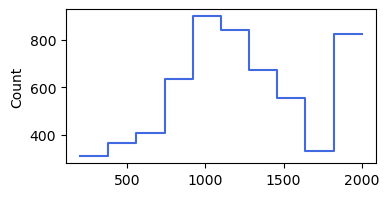

In [143]:
plt.figure(figsize=(4,2))
# sns.violinplot(tss_in_init,color="skyblue")
sns.histplot(tss_in_init,bins=10,color="royalblue", fill=False, element="step")

### And then, how are the other chromatin states in the initial position

In [136]:
from collections import Counter

# Let's suppose this is your dataset
# dataset = ["ABCDEFGHIJ", "ABCDKLMNOP", "OABCDEFGHI", "ABCDEFGHIJ", "AAAAAOOOOO"]
dataset=flat_tss_by_init

# Flatten the dataset into a single string
data_str = "".join(dataset)

# Count occurrences of each character
char_counts = Counter(data_str)

# Initialize the dictionary for the characters from "A" to "O"
counts = {chr(i+65): 0 for i in range(15)}

# Update the counts for the characters found in the data
counts.update(char_counts)

print(counts)


{'A': 34746, 'B': 3424, 'C': 939, 'D': 7491, 'E': 42583, 'F': 707, 'G': 8284, 'H': 1083, 'I': 1992, 'J': 12863, 'K': 1032, 'L': 1897, 'M': 9541, 'N': 14291, 'O': 70598}


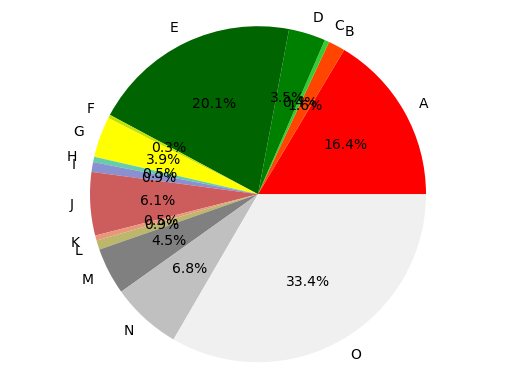

In [148]:
fig, ax = plt.subplots()
ax.pie(counts.values(), labels=counts.keys(), colors=[state_col_dict[key] for key in counts.keys()], autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Overall, how many genes have Active TSS ("A") in a sample cell

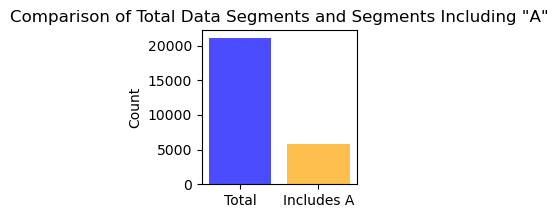

In [167]:
import matplotlib.pyplot as plt

total =len(flat_tss_by_init)
includes_A = len(tss_in_init)  # adjust as per your actual data

# Define labels, positions, bar heights and colors
labels = ['Total', 'Includes A']
x_pos = range(len(labels))
counts = [total, includes_A]
colors = ['blue', 'orange']

# Create bar chart
plt.figure(figsize=(2,2))
plt.bar(x_pos, counts, align='center', alpha=0.7, color=colors)
plt.xticks(x_pos, labels)
plt.ylabel('Count')
plt.title('Comparison of Total Data Segments and Segments Including "A"')

# Show the chart
plt.show()



## Now turn to "windowed" version

### how long Active TSS marks ("A"s) are, in -2kb to 4kb?

In [151]:
# gene_start_lst_all, tss_by_loc_css_unit_all, tss_by_init_css_unit_all are the result from the previous function

In [157]:
tss_by_loc_css_unit_all[5][30]

'EEEEEEGAAAAAAAAAAABGEEEEEEEEEE'

In [158]:
tss_by_init_css_unit_all[5][30]

'AAAAAAAABG'

In [159]:
win_tss_all=flatLst(tss_by_loc_css_unit_all)

In [162]:
tss_in_win=[]
for init_pos in win_tss_all:
    if "A" in init_pos:
        tss_win_len=init_pos.count("A")*200
        tss_in_win.append(tss_win_len)

In [165]:
len(tss_in_win)

6893

<Axes: ylabel='Count'>

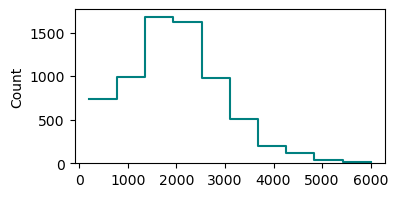

In [164]:
plt.figure(figsize=(4,2))
# sns.violinplot(tss_in_init,color="skyblue")
sns.histplot(tss_in_win,bins=10,color="teal", fill=False, element="step")

### And then, how are the other chromatin states in the initial position

In [169]:
from collections import Counter

# Let's suppose this is your dataset
# dataset = ["ABCDEFGHIJ", "ABCDKLMNOP", "OABCDEFGHI", "ABCDEFGHIJ", "AAAAAOOOOO"]
dataset=win_tss_all

# Flatten the dataset into a single string
data_str = "".join(dataset)

# Count occurrences of each character
char_counts = Counter(data_str)

# Initialize the dictionary for the characters from "A" to "O"
counts = {chr(i+65): 0 for i in range(15)}

# Update the counts for the characters found in the data
counts.update(char_counts)

print(counts)

{'A': 68196, 'B': 8498, 'C': 1985, 'D': 24180, 'E': 146932, 'F': 2203, 'G': 29035, 'H': 2957, 'I': 7512, 'J': 24909, 'K': 2649, 'L': 5844, 'M': 29799, 'N': 52944, 'O': 226783}


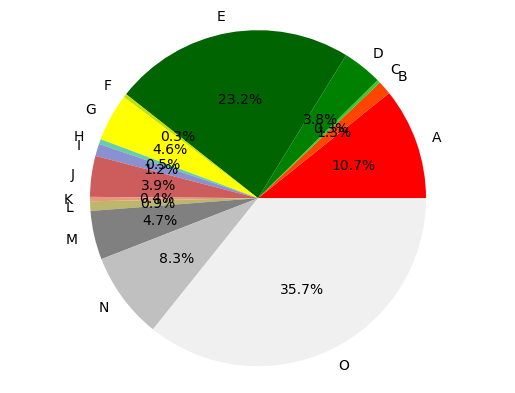

In [170]:
fig, ax = plt.subplots()
ax.pie(counts.values(), labels=counts.keys(), colors=[state_col_dict[key] for key in counts.keys()], autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Overall, how many genes have Active TSS ("A") in a sample cell

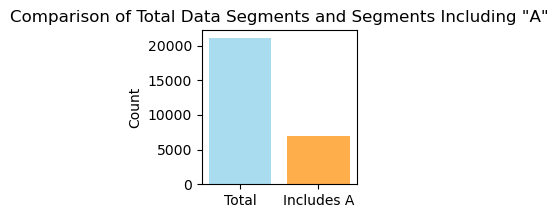

In [171]:
import matplotlib.pyplot as plt

total =len(win_tss_all)
includes_A = len(tss_in_win)  # adjust as per your actual data

# Define labels, positions, bar heights and colors
labels = ['Total', 'Includes A']
x_pos = range(len(labels))
counts = [total, includes_A]
colors = ['skyblue', 'darkorange']

# Create bar chart
plt.figure(figsize=(2,2))
plt.bar(x_pos, counts, align='center', alpha=0.7, color=colors)
plt.xticks(x_pos, labels)
plt.ylabel('Count')
plt.title('Comparison of Total Data Segments and Segments Including "A"')

# Show the chart
plt.show()

## Per genic region, how many (a sequential) promoters are there

In [156]:
import pandas as pd
from collections import defaultdict
import re

def css_freq_len(css_lst, unit=200):
    strings=[item for item in css_lst if item!='']
    result = defaultdict(lambda: {'count': [], 'lengths': [], 'relative_position': []})
    for string in strings:  # Iterate over each string in the list
        total_length = len(string)
        for char in set(string):  # loop through unique characters in the string
            pattern = re.compile(f'{char}+')
            matches = pattern.findall(string)
            count = len(matches)
            lengths = [len(match)*unit for match in matches]  # multiplied by unit to make it real length
            for match in matches:
                relative_position = round(((string.index(match) / total_length) * 100) + 1, 2)
                result[char]['relative_position'].append(relative_position)
            result[char]['count'].append(count)
            result[char]['lengths'].extend(lengths)  # Use extend instead of append here
    result = dict(result)
    # Sort dictionary
    sorted_result = OrderedDict(sorted(result.items()))

    # Convert the dictionary to a DataFrame
    df_cs_wise = pd.DataFrame(sorted_result).transpose()  # transpose to have letters as the index

    return df_cs_wise

strings = ["EDDDDEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE",
           "DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDEFFBAAAAAAAAAAAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEDDDDDDDDDDDDDDDDDEEEEEEEE",
           "EEEEEEEEEEEEEEEEEEEEEEEEEEE"]
result = css_freq_len(strings)
print(result)


       count                              lengths  \
A        [1]                               [2800]   
B        [1]                                [200]   
D     [1, 2]                    [800, 7200, 3400]   
E  [2, 3, 1]  [200, 12400, 200, 6200, 1600, 5400]   
F        [1]                                [400]   

                       relative_position  
A                                [37.36]  
B                                [36.45]  
D                       [2.49, 1.0, 1.0]  
E  [1.0, 8.46, 33.73, 50.09, 50.09, 1.0]  
F                                [34.64]  


In [160]:
with open("../database/roadmap/gene_css_unit_pickled/E001_gene_css_pickled.pkl","rb") as f:
    g_e001=pickle.load(f)

In [161]:
g_e001_all=flatLst(g_e001)

In [162]:
g_e001_all=[item for item in g_e001_all if item!='']

In [163]:
df_g_e001=css_freq_len(g_e001_all, unit=200)

In [215]:
import matplotlib.ticker as ticker

In [289]:
def df_cs_wise2fig(df_cs_wise, chromatin_state="A"):
    color=state_col_dict[chromatin_state]
    count_cs=df_cs_wise.loc[chromatin_state]["count"]
    len_cs=df_cs_wise.loc[chromatin_state]["lengths"]
    rel_pos_cs=df_cs_wise.loc[chromatin_state]["relative_position"]

    #### scaler for Z score = (x-mean)/std ####
    def standard_scaler(data):
        data_np = np.array(data)  # Convert to numpy array
        return (data_np - np.mean(data_np)) / np.std(data_np)
    ###########################################
    
    norm_len_cs = standard_scaler(len_cs)
    norm_rel_pos_cs = standard_scaler(rel_pos_cs)
    
    df_len_rel_pos = pd.DataFrame({'norm_len': norm_len_cs, 'norm_rel_pos': norm_rel_pos_cs})
    # Calculate the correlation matrix
    len_rel_pos_corr = df_len_rel_pos.corr()
    
    fig, axs = plt.subplots(1, 3, figsize=(7, 2.8))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    sns.violinplot(count_cs, color=color, linewidth=0.8, ax=axs[0])
    axs[0].set_xlabel('Count')
    axs[0].set_xticklabels([])  # Remove xtick labels
    mean_count_cs = np.mean(count_cs)  # Calculate the mean
    axs[0].annotate('Mean: {:.2f}'.format(mean_count_cs), xy=(0, 1.05), xycoords=axs[0].transAxes)  # Annotate the mean
    axs[0].tick_params(axis='y', labelsize='small')

    def thousands(x, pos):
        """The two args are the value and tick position"""
        return '%1.0fK' % (x * 1e-3) if x >= 1000 else '%1.0f' % x

    formatter = ticker.FuncFormatter(thousands)

    sns.violinplot(len_cs, color=color,  linewidth=0.8, ax=axs[1])
    axs[1].set_xlabel('Length (bps)')

    axs[1].yaxis.set_major_formatter(formatter)

    axs[1].set_xticklabels([])  # Remove xtick labels
    mean_len_cs = np.mean(len_cs)  # Calculate the mean
    axs[1].annotate('Mean: {:.1f}'.format(mean_len_cs), xy=(0, 1.05), xycoords=axs[1].transAxes)  # Annotate the mean
    axs[1].tick_params(axis='y', labelsize='small')

    
    sns.violinplot(rel_pos_cs, color=color, linewidth=0.8, ax=axs[2])
    axs[2].set_xlabel('Rel_pos (%)')
    axs[2].set_xticklabels([])  # Remove xtick labels
    mean_rel_pos_cs = np.mean(rel_pos_cs) # Calculate the mean
    axs[2].annotate('Mean: {:.1f}'.format(mean_rel_pos_cs), xy=(0, 1.05), xycoords=axs[2].transAxes)  # Annotate the mean
    axs[2].tick_params(axis='y', labelsize='small')
    
    fig2,axs2=plt.subplots(1, 2, figsize=(7, 3))
    sns.heatmap(len_rel_pos_corr, annot=True, cmap='Blues',  ax=axs2[0])    
    sns.scatterplot(x=norm_len_cs,y=norm_rel_pos_cs, ax=axs2[1])

    plt.tight_layout()
    plt.show()
    return len_rel_pos_corr

In [290]:
g_e001_all=[item for item in g_e001_all if item!='']
df_cs_wise=df_g_e001

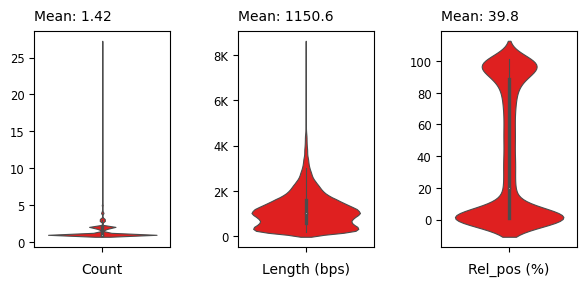

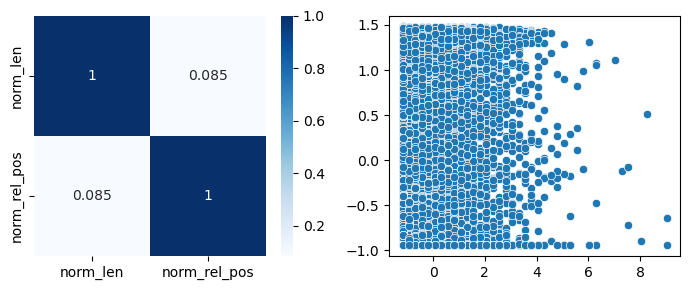

,norm_len,norm_rel_pos
norm_len,1.000000,0.085345
norm_rel_pos,0.085345,1.000000


In [291]:
df_cs_wise2fig(df_cs_wise, chromatin_state="A")

In [63]:
def shorten_string(s, factor):
    # This regular expression matches groups of the same character.
    pattern = re.compile(r'(.)\1*')

    # This function will be used to replace each match.
    def replacer(match):
        # The group that was matched.
        group = match.group()

        # Calculate the new length, rounding as necessary.
        new_length = round(len(group) / factor)

        # Return the character repeated the new number of times.
        return group[0] * new_length

    # Use re.sub to replace each match in the string.
    return pattern.sub(replacer, s)

In [64]:
def Convert2unitCSS_main_new(css_lst_all, unit=200):# should be either css_gene_lst_all or css_Ngene_lst_all
    """
    Input: css_gene_lst_all or css_Ngene_lst_all, the list of chromosome-wise list of the css in genic, intergenic regions.
    Output: css_gene_unit_lst_all or css_Ngene_unit_lst_all
    """
    reduced_all=[]
    for i in range(len(css_lst_all)):
        reduced_chr=[]
        for j in range(len(css_lst_all[i])):
            reduced=shorten_string(css_lst_all[i][j], unit)
            reduced_chr.append(reduced)
        reduced_all.append(reduced_chr)
    return reduced_all